# Structure-Based Substitution Matrix Generation

This notebook implements the makesubmat.py logic with real-time visualizations to monitor matrix convergence during compilation.

## Workflow Overview
1. Load trained FoldTree2 encoder model
2. Encode protein structures into discrete structural tokens
3. Process structural alignments iteratively
4. Visualize matrix changes and convergence metrics
5. Generate final MAFFT and RAxML compatible matrices

## Convergence Monitoring
We track:
- **Matrix Frobenius Norm**: Overall magnitude of changes
- **Gradient Norm**: Rate of change between iterations
- **Element-wise Variance**: Stability of individual substitution scores
- **Heatmap Evolution**: Visual progression of the matrix structure

In [22]:
# Imports
import sys
import os
import pickle
import glob
import pandas as pd
import numpy as np
import tqdm
import torch
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

# FoldTree2 imports
from foldtree2.src import AFDB_tools, foldseek2tree
from foldtree2.src.pdbgraph import PDB2PyG, StructureDataset
import foldtree2.src.encoder as ft2
from torch_geometric.data import DataLoader

print("Imports complete!")

Imports complete!


In [27]:
# Configuration Parameters
modelname = 'embedding_comparison/final/ft2_35_embeddings_big_best_encoder'  # Model name without .pt extension
modeldir = './models/'
datadir = '/mnt/data2/datasets/'
dataset_path = './foldtree2/structalnfinal.h5'
fident_thresh = 0.3  # Sequence identity threshold for alignments
output_dir = './models/'

# Visualization parameters
update_interval = 5  # Update plots every N alignment files
figsize = (18, 12)

print(f"Configuration:")
print(f"  Model: {modelname}")
print(f"  Model dir: {modeldir}")
print(f"  Data dir: {datadir}")
print(f"  Dataset: {dataset_path}")
print(f"  Identity threshold: {fident_thresh}")
print(f"  Visualization update interval: {update_interval} files")

Configuration:
  Model: embedding_comparison/final/ft2_35_embeddings_big_best_encoder
  Model dir: ./models/
  Data dir: /mnt/data2/datasets/
  Dataset: ./foldtree2/structalnfinal.h5
  Identity threshold: 0.3
  Visualization update interval: 5 files


In [28]:
cd /home/dmoi/projects/foldtree2/

/home/dmoi/projects/foldtree2


In [29]:
# Load trained encoder model
model_path = os.path.join(modeldir, modelname + '.pt')
print(f"Loading model from: {model_path}")

encoder = torch.load(model_path, map_location=torch.device('cpu'), weights_only=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
encoder = encoder.to(device)
encoder.device = device
encoder.eval()

print(f"Using device: {device}")
print(f"Number of embeddings: {encoder.num_embeddings}")
print(f"Embedding dimension: {encoder.out_channels if hasattr(encoder, 'out_channels') else 'N/A'}")
print("\nEncoder architecture:")
print(encoder)

Loading model from: ./models/embedding_comparison/final/ft2_35_embeddings_big_best_encoder.pt
Using device: cuda:0
Number of embeddings: 35
Embedding dimension: 128

Encoder architecture:
mk1_Encoder(
  (position_mlp): Position_MLP(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): GELU(approximate='none')
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): GELU(approximate='none')
      (5): Dropout(p=0, inplace=False)
      (6): Linear(in_features=128, out_features=64, bias=True)
      (7): GELU(approximate='none')
      (8): Dropout(p=0, inplace=False)
      (9): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (input): ModuleDict(
    (dropout): Dropout(p=0.005, inplace=False)
    (ln): LayerNorm((857,), eps=1e-06, elementwise_affine=True)
    (inmlp): Sequential(
      (0): Dropout(p=0.005, inplace=False)
      (1): LayerNorm((889,), eps=1e-06, elementwise_af

In [30]:
# Helper Functions

def encode_structures(encoder, device, dataset_path):
	"""Encode protein structures using trained model."""
	if os.path.exists(dataset_path):
		print(f"Loading dataset from {dataset_path}")
		struct_dat = StructureDataset(dataset_path)
	else:
		print(f"Dataset {dataset_path} not found!")
		return None
	
	print(f"Loaded {len(struct_dat)} structures")
	encoder_loader = DataLoader(struct_dat, batch_size=1, shuffle=False)
	
	def databatch2list(loader):
		for data in loader:
			data = data.to_data_list()
			for d in data:
				d = d.to(device)
				yield d
	
	encoder_loader = databatch2list(encoder_loader)
	
	# Encode structures
	output_path = os.path.join(output_dir, modelname + '_aln_encoded.fasta')
	encoder.encode_structures_fasta(encoder_loader, output_path, replace=True)
	print(f"Encoded structures saved to {output_path}")
	return output_path

def build_char_set(encoded_df):
	"""Build character set and position mappings."""
	char_set = set()
	for seq in encoded_df.seq:
		char_set = char_set.union(set(seq))
	char_set = list(char_set)
	char_set.sort()
	
	print(f"Character set size: {len(char_set)}")
	print(f"Characters (ord): {[ord(c) for c in char_set[:10]]}... ({len(char_set)} total)")
	
	char_position_map = {char: i for i, char in enumerate(char_set)}
	
	# Create RAxML compatible character set
	raxml_chars = """0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z ! " # $ % & ' ( ) * + , / : ; < = > @ [ \ ] ^ _ { | } ~""".split()
	raxml_charset = [raxml_chars[char_position_map[c]] for c in char_set]
	raxml_char_position_map = {c: i for i, c in enumerate(raxml_charset)}
	
	assert len(raxml_charset) == len(char_set), "Character set length mismatch"
	
	return char_set, char_position_map, raxml_charset, raxml_char_position_map

def compute_log_odds_from_counts(pair_counts, char_freqs, pseudocount=1e-20, log_base=np.e):
	"""Compute log-odds substitution scores from pair counts."""
	n = pair_counts.shape[0]
	total_pairs = np.sum(pair_counts)
	obs_freq = (pair_counts + pseudocount) / (total_pairs + pseudocount * (n**2))
	char_freqs = char_freqs / np.sum(char_freqs)
	exp_freq = np.outer(char_freqs, char_freqs) + pseudocount
	ratio = obs_freq / exp_freq
	epsilon = 1e-15
	log_odds_matrix = np.log(ratio + epsilon) / np.log(log_base)
	return log_odds_matrix

print("Helper functions defined!")

Helper functions defined!


In [31]:
# Visualization Functions

class MatrixConvergenceMonitor:
	"""Track and visualize matrix convergence during compilation."""
	
	def __init__(self, matrix_size):
		self.matrix_size = matrix_size
		self.history = {
			'iteration': [],
			'frobenius_norm': [],
			'gradient_norm': [],
			'max_change': [],
			'mean_change': [],
			'nonzero_elements': [],
			'snapshots': []
		}
		self.prev_matrix = None
		
	def update(self, iteration, current_matrix):
		"""Update convergence metrics with new matrix state."""
		# Frobenius norm
		frob_norm = np.linalg.norm(current_matrix, 'fro')
		
		# Gradient (change from previous iteration)
		if self.prev_matrix is not None:
			gradient = current_matrix - self.prev_matrix
			grad_norm = np.linalg.norm(gradient, 'fro')
			max_change = np.max(np.abs(gradient))
			mean_change = np.mean(np.abs(gradient))
		else:
			grad_norm = 0
			max_change = 0
			mean_change = 0
		
		# Non-zero elements
		nonzero = np.count_nonzero(current_matrix)
		
		# Store metrics
		self.history['iteration'].append(iteration)
		self.history['frobenius_norm'].append(frob_norm)
		self.history['gradient_norm'].append(grad_norm)
		self.history['max_change'].append(max_change)
		self.history['mean_change'].append(mean_change)
		self.history['nonzero_elements'].append(nonzero)
		self.history['snapshots'].append(current_matrix.copy())
		
		self.prev_matrix = current_matrix.copy()
	
	def plot_convergence(self, figsize=(18, 12)):
		"""Generate comprehensive convergence visualization."""
		fig, axes = plt.subplots(3, 3, figsize=figsize)
		
		iterations = self.history['iteration']
		
		# Row 1: Convergence metrics
		axes[0, 0].plot(iterations, self.history['frobenius_norm'], 'b-', linewidth=2)
		axes[0, 0].set_xlabel('Iteration (Alignment Files)')
		axes[0, 0].set_ylabel('Frobenius Norm')
		axes[0, 0].set_title('Matrix Magnitude Over Time')
		axes[0, 0].grid(True, alpha=0.3)
		
		axes[0, 1].plot(iterations, self.history['gradient_norm'], 'r-', linewidth=2)
		axes[0, 1].set_xlabel('Iteration (Alignment Files)')
		axes[0, 1].set_ylabel('Gradient Norm')
		axes[0, 1].set_title('Rate of Change (Matrix Gradient)')
		axes[0, 1].grid(True, alpha=0.3)
		axes[0, 1].set_yscale('log')
		
		axes[0, 2].plot(iterations, self.history['max_change'], 'g-', label='Max', linewidth=2)
		axes[0, 2].plot(iterations, self.history['mean_change'], 'orange', label='Mean', linewidth=2)
		axes[0, 2].set_xlabel('Iteration (Alignment Files)')
		axes[0, 2].set_ylabel('Change Magnitude')
		axes[0, 2].set_title('Element-wise Changes')
		axes[0, 2].legend()
		axes[0, 2].grid(True, alpha=0.3)
		axes[0, 2].set_yscale('log')
		
		# Row 2: Matrix snapshots (early, middle, recent)
		if len(self.history['snapshots']) > 0:
			# First snapshot
			im0 = axes[1, 0].imshow(self.history['snapshots'][0], cmap='RdBu_r', 
								   aspect='auto', interpolation='nearest')
			axes[1, 0].set_title(f'Iteration {iterations[0]} (First)')
			plt.colorbar(im0, ax=axes[1, 0], fraction=0.046)
			
			# Middle snapshot
			mid_idx = len(self.history['snapshots']) // 2
			im1 = axes[1, 1].imshow(self.history['snapshots'][mid_idx], cmap='RdBu_r',
								   aspect='auto', interpolation='nearest')
			axes[1, 1].set_title(f'Iteration {iterations[mid_idx]} (Middle)')
			plt.colorbar(im1, ax=axes[1, 1], fraction=0.046)
			
			# Latest snapshot
			im2 = axes[1, 2].imshow(self.history['snapshots'][-1], cmap='RdBu_r',
								   aspect='auto', interpolation='nearest')
			axes[1, 2].set_title(f'Iteration {iterations[-1]} (Current)')
			plt.colorbar(im2, ax=axes[1, 2], fraction=0.046)
		
		# Row 3: Additional metrics
		axes[2, 0].plot(iterations, self.history['nonzero_elements'], 'purple', linewidth=2)
		axes[2, 0].set_xlabel('Iteration (Alignment Files)')
		axes[2, 0].set_ylabel('Count')
		axes[2, 0].set_title('Non-zero Matrix Elements')
		axes[2, 0].grid(True, alpha=0.3)
		
		# Convergence rate (derivative of gradient norm)
		if len(iterations) > 2:
			grad_norms = np.array(self.history['gradient_norm'])
			convergence_rate = np.diff(grad_norms)
			axes[2, 1].plot(iterations[1:], convergence_rate, 'cyan', linewidth=2)
			axes[2, 1].set_xlabel('Iteration (Alignment Files)')
			axes[2, 1].set_ylabel('Δ(Gradient Norm)')
			axes[2, 1].set_title('Convergence Acceleration')
			axes[2, 1].grid(True, alpha=0.3)
			axes[2, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
		
		# Summary statistics
		if len(iterations) > 0:
			stats_text = f"""Matrix Convergence Summary
			
Final Iteration: {iterations[-1]}
Final Frobenius Norm: {self.history['frobenius_norm'][-1]:.4f}
Final Gradient Norm: {self.history['gradient_norm'][-1]:.6f}
Mean Gradient Norm: {np.mean(self.history['gradient_norm'][1:]):.6f}
Non-zero Elements: {self.history['nonzero_elements'][-1]} / {self.matrix_size**2}
Sparsity: {100*(1 - self.history['nonzero_elements'][-1]/(self.matrix_size**2)):.2f}%

Convergence Status:
{'✓ CONVERGED' if self.history['gradient_norm'][-1] < 0.01 else '⚠ STILL CHANGING'}
			"""
			axes[2, 2].text(0.1, 0.5, stats_text, fontsize=10, 
						   verticalalignment='center', family='monospace')
			axes[2, 2].axis('off')
		
		plt.tight_layout()
		return fig
	
	def get_convergence_summary(self):
		"""Return summary statistics about convergence."""
		if len(self.history['iteration']) == 0:
			return "No data collected yet."
		
		return {
			'total_iterations': len(self.history['iteration']),
			'final_frobenius_norm': self.history['frobenius_norm'][-1],
			'final_gradient_norm': self.history['gradient_norm'][-1],
			'mean_gradient_norm': np.mean(self.history['gradient_norm'][1:]),
			'max_gradient_norm': np.max(self.history['gradient_norm']),
			'is_converged': self.history['gradient_norm'][-1] < 0.01,
			'sparsity': 1 - self.history['nonzero_elements'][-1] / (self.matrix_size**2)
		}

print("Visualization functions defined!")

Visualization functions defined!


In [32]:
print( encoder.out_channels )

128


In [33]:
# Load or encode structures
encoded_fasta_path = os.path.join(output_dir, modelname + '_aln_encoded.fasta')
overwrite_encoding = False  # Set to True to re-encode structures
if overwrite_encoding:
	print("Overwriting existing encoded FASTA...")
if os.path.exists(encoded_fasta_path) and not overwrite_encoding:
	print(f"Using existing encoded FASTA: {encoded_fasta_path}")
else:
	print("Encoding structures (this may take a while)...")
	encoded_fasta_path = encode_structures(encoder, device, dataset_path)

# Load encoded sequences
encoded_df = ft2.load_encoded_fasta(encoded_fasta_path, alphabet=None, replace=False)
print(f"\nLoaded {len(encoded_df)} encoded sequences")
print(f"Sample sequence length: {len(encoded_df.iloc[0].seq)}")
print(f"First sequence ID: {encoded_df.index[0]}")

# Build character set
char_set, char_position_map, raxml_charset, raxml_char_position_map = build_char_set(encoded_df)
matrix_size = len(char_set)
print(f"\nMatrix size: {matrix_size} x {matrix_size}")

Encoding structures (this may take a while)...
Loading dataset from ./foldtree2/structalnfinal.h5
Loaded 45853 structures


Encoding structures to FASTA: 45853it [37:27, 20.40it/s]


Encoded structures saved to ./models/embedding_comparison/final/ft2_35_embeddings_big_best_encoder_aln_encoded.fasta


91706it [00:00, 543638.67it/s]



Loaded 45852 encoded sequences
Sample sequence length: 41
First sequence ID: A0A009E921
Character set size: 16
Characters (ord): [1, 3, 4, 5, 8, 14, 16, 17, 21, 24]... (16 total)

Matrix size: 16 x 16


In [34]:
# Find alignment files (faster than glob by scanning one level with os.scandir)
find_alns = True  # Set to False to skip searching for alignment files
print("Searching for alignment files...")
base = os.path.join(datadir, 'struct_align')
if not os.path.isdir(base):
	alnfiles = []
	print(f"ERROR: Base directory not found: {base}")
else:
	alnfiles = glob.glob(os.path.join(base, '*/allvall.csv'))  # Warm up glob cache
	print(f"Found {len(alnfiles)} alignment files")

Searching for alignment files...
Found 20349 alignment files


## Process Alignments with Real-Time Convergence Monitoring

The next cell processes structural alignments iteratively, updating the substitution matrix and visualizing convergence metrics in real-time.

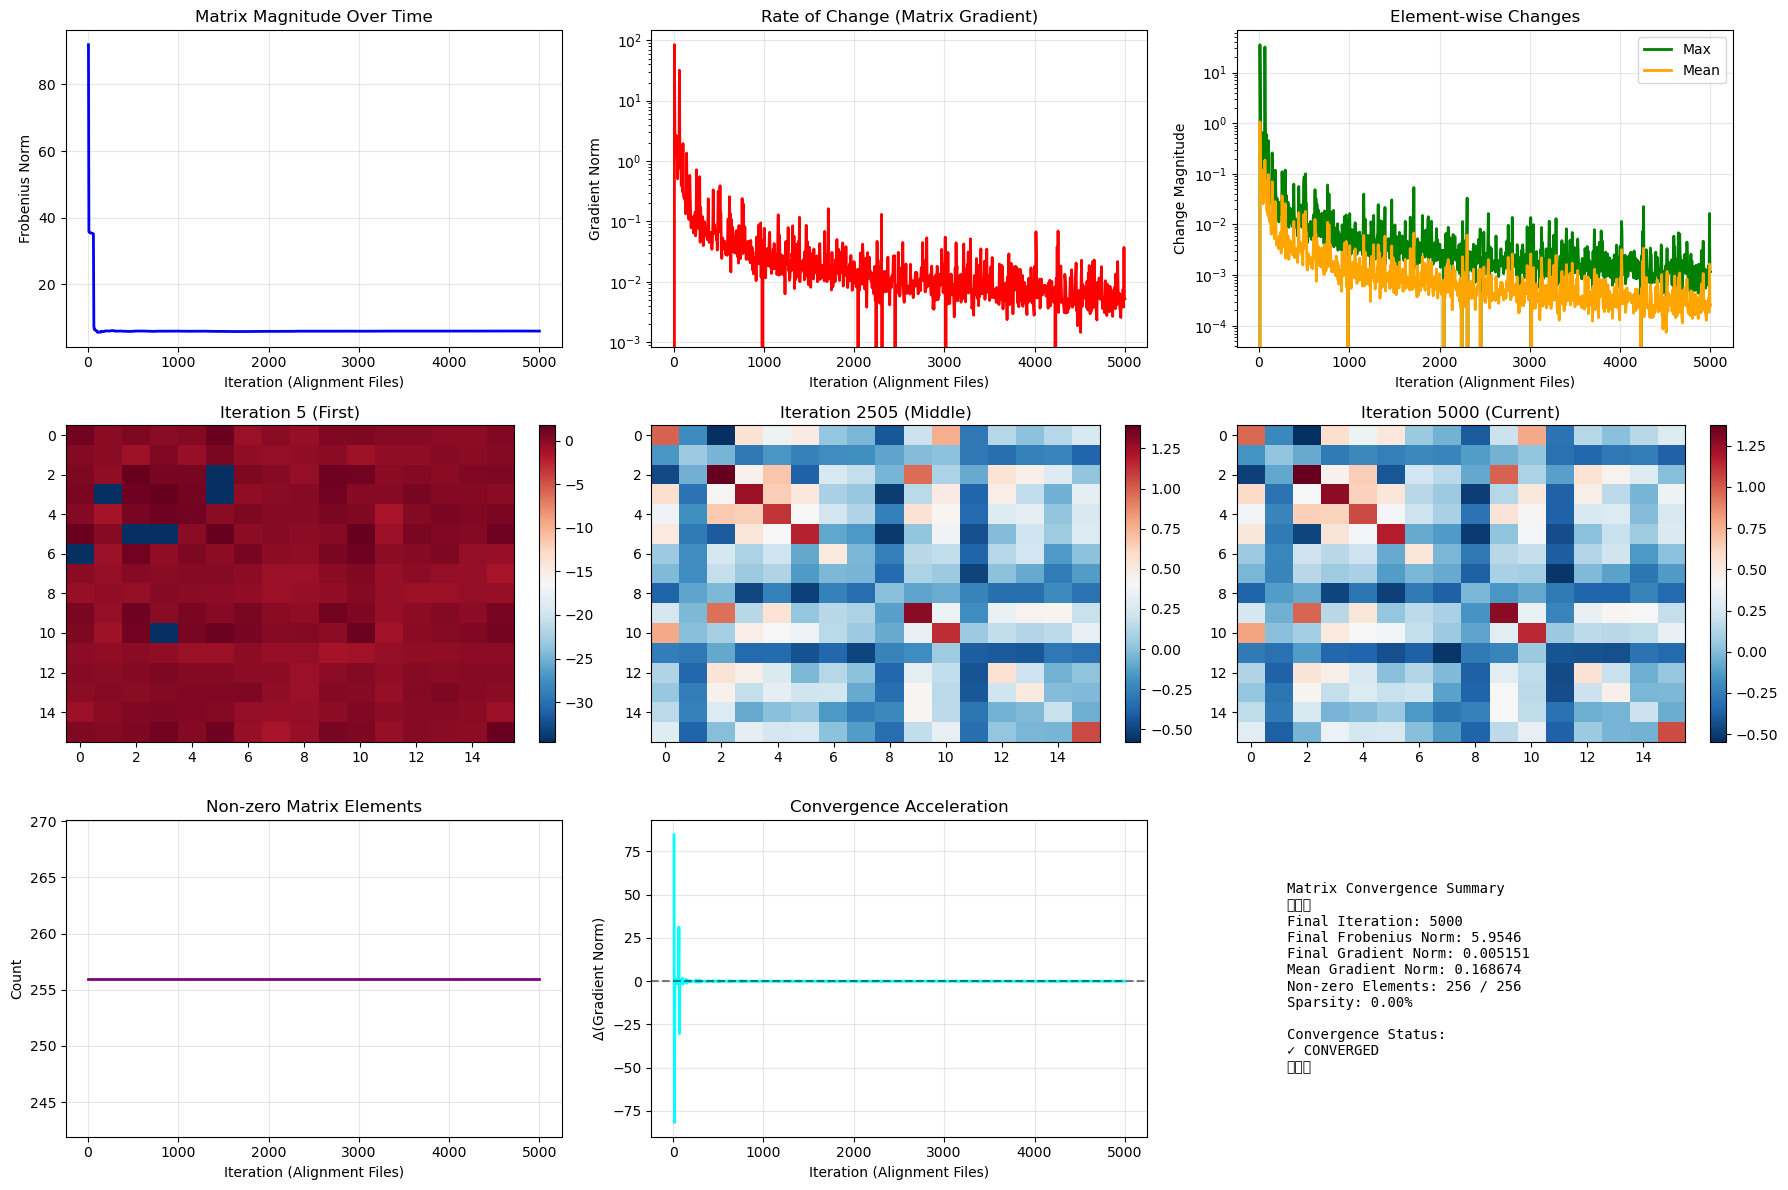

Processing alignments:  25%|██▍       | 5000/20349 [37:33<1:55:16,  2.22it/s]


Progress: 5000/20349 files (24.6%)
Processed sequences: 7664
Total sequence positions: 2112898
Gradient norm: 0.005151
Converged: True

Reached alignment file limit of 5000. Stopping processing.

Alignment processing complete!


In [35]:
# Process alignments iteratively with convergence monitoring
cols = 'query,target,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qaln,taln'.split(',')

# Initialize matrices and convergence monitor
pair_counts = np.zeros((matrix_size, matrix_size))
background_freq = np.zeros(matrix_size)
seqcount = 0
monitor = MatrixConvergenceMonitor(matrix_size)

# Track processed sequences to avoid double-counting
all_processed_seqs = set()
alnlimit = 5000  # Set a limit on the number of alignment files to process (for testing)

print(f"Processing {len(alnfiles)} alignment files...")
print(f"Visualization updates every {update_interval} files\n")

for file_idx, aln_file in enumerate(tqdm.tqdm(alnfiles, desc="Processing alignments")):
	if file_idx >= alnlimit:
		print(f"Reached alignment file limit of {alnlimit}. Stopping processing.")
		break
	# Read alignment file
	try:
		aln_df = pd.read_table(aln_file)
		aln_df.columns = cols
	except Exception as e:
		print(f"Warning: Could not read {aln_file}: {e}")
		continue
	
	# Track sequences in this file
	file_seqset = set()
	
	# Process pairwise alignments
	for q in aln_df['query'].unique():
		for t in aln_df['target'].unique():
			if q != t:
				aln = aln_df[(aln_df['query'] == q) & (aln_df['target'] == t)]
				
				if len(aln) > 0 and aln.fident.iloc[0] < fident_thresh:
					aln = aln.iloc[0]
					qaln = aln.qaln
					taln = aln.taln
					qaccession = q.split('.')[0]
					taccession = t.split('.')[0]
					
					if qaccession in encoded_df.index and taccession in encoded_df.index:
						# Get encoded sequences for aligned regions
						qz = str(encoded_df.loc[qaccession].seq[aln.qstart-1:aln.qend])
						tz = str(encoded_df.loc[taccession].seq[aln.tstart-1:aln.tend])
						
						# Update background frequencies (only once per sequence)
						if qaccession not in all_processed_seqs:
							background_freq += np.array([qz.count(c) for c in char_set])
							file_seqset.add(qaccession)
							all_processed_seqs.add(qaccession)
							seqcount += len(qz)
						
						if taccession not in all_processed_seqs:
							background_freq += np.array([tz.count(c) for c in char_set])
							file_seqset.add(taccession)
							all_processed_seqs.add(taccession)
							seqcount += len(tz)
						
						# Check alignment lengths match
						if len(qz) == len(qaln.replace('-','')) and len(tz) == len(taln.replace('-','')):
							# Map aligned positions to character indices
							qz_iter = iter(qz)
							tz_iter = iter(tz)
							qaln_ft2, taln_ft2 = [], []
							
							for q_char in qaln:
								if q_char == '-':
									qaln_ft2.append(None)
								else:
									qaln_ft2.append(char_position_map[next(qz_iter)])
							
							for t_char in taln.strip():
								if t_char == '-':
									taln_ft2.append(None)
								else:
									taln_ft2.append(char_position_map[next(tz_iter)])
							
							# Count substitution pairs
							alnzip = [[a, b] for a, b in zip(qaln_ft2, taln_ft2) 
									 if a is not None and b is not None]
							
							if len(alnzip) > 0:
								alnzip = np.array(alnzip)
								pair_counts[alnzip[:,0], alnzip[:,1]] += 1
	
	# Update convergence monitor at regular intervals
	if (file_idx + 1) % update_interval == 0 or file_idx == len(alnfiles) - 1:
		# Compute current log-odds matrix
		current_log_odds = compute_log_odds_from_counts(pair_counts, background_freq)
		
		# Update monitor
		monitor.update(file_idx + 1, current_log_odds)
		
		# Display convergence plots
		clear_output(wait=True)
		fig = monitor.plot_convergence(figsize=figsize)
		plt.show()
		
		# Print current status
		summary = monitor.get_convergence_summary()
		print(f"\n{'='*80}")
		print(f"Progress: {file_idx + 1}/{len(alnfiles)} files ({100*(file_idx+1)/len(alnfiles):.1f}%)")
		print(f"Processed sequences: {len(all_processed_seqs)}")
		print(f"Total sequence positions: {seqcount}")
		print(f"Gradient norm: {summary['final_gradient_norm']:.6f}")
		print(f"Converged: {summary['is_converged']}")
		print(f"{'='*80}\n")

print("\nAlignment processing complete!")

FINAL CONVERGENCE SUMMARY
total_iterations: 1000
final_frobenius_norm: 5.954636
final_gradient_norm: 0.005151
mean_gradient_norm: 0.168674
max_gradient_norm: 84.700910
is_converged: True
sparsity: 0.000000

Total pair counts: 1445991
Non-zero pairs: 256
Sparsity: 0.00%



Saved convergence plot to: ./models/embedding_comparison/final/ft2_35_embeddings_big_best_encoder_convergence.png


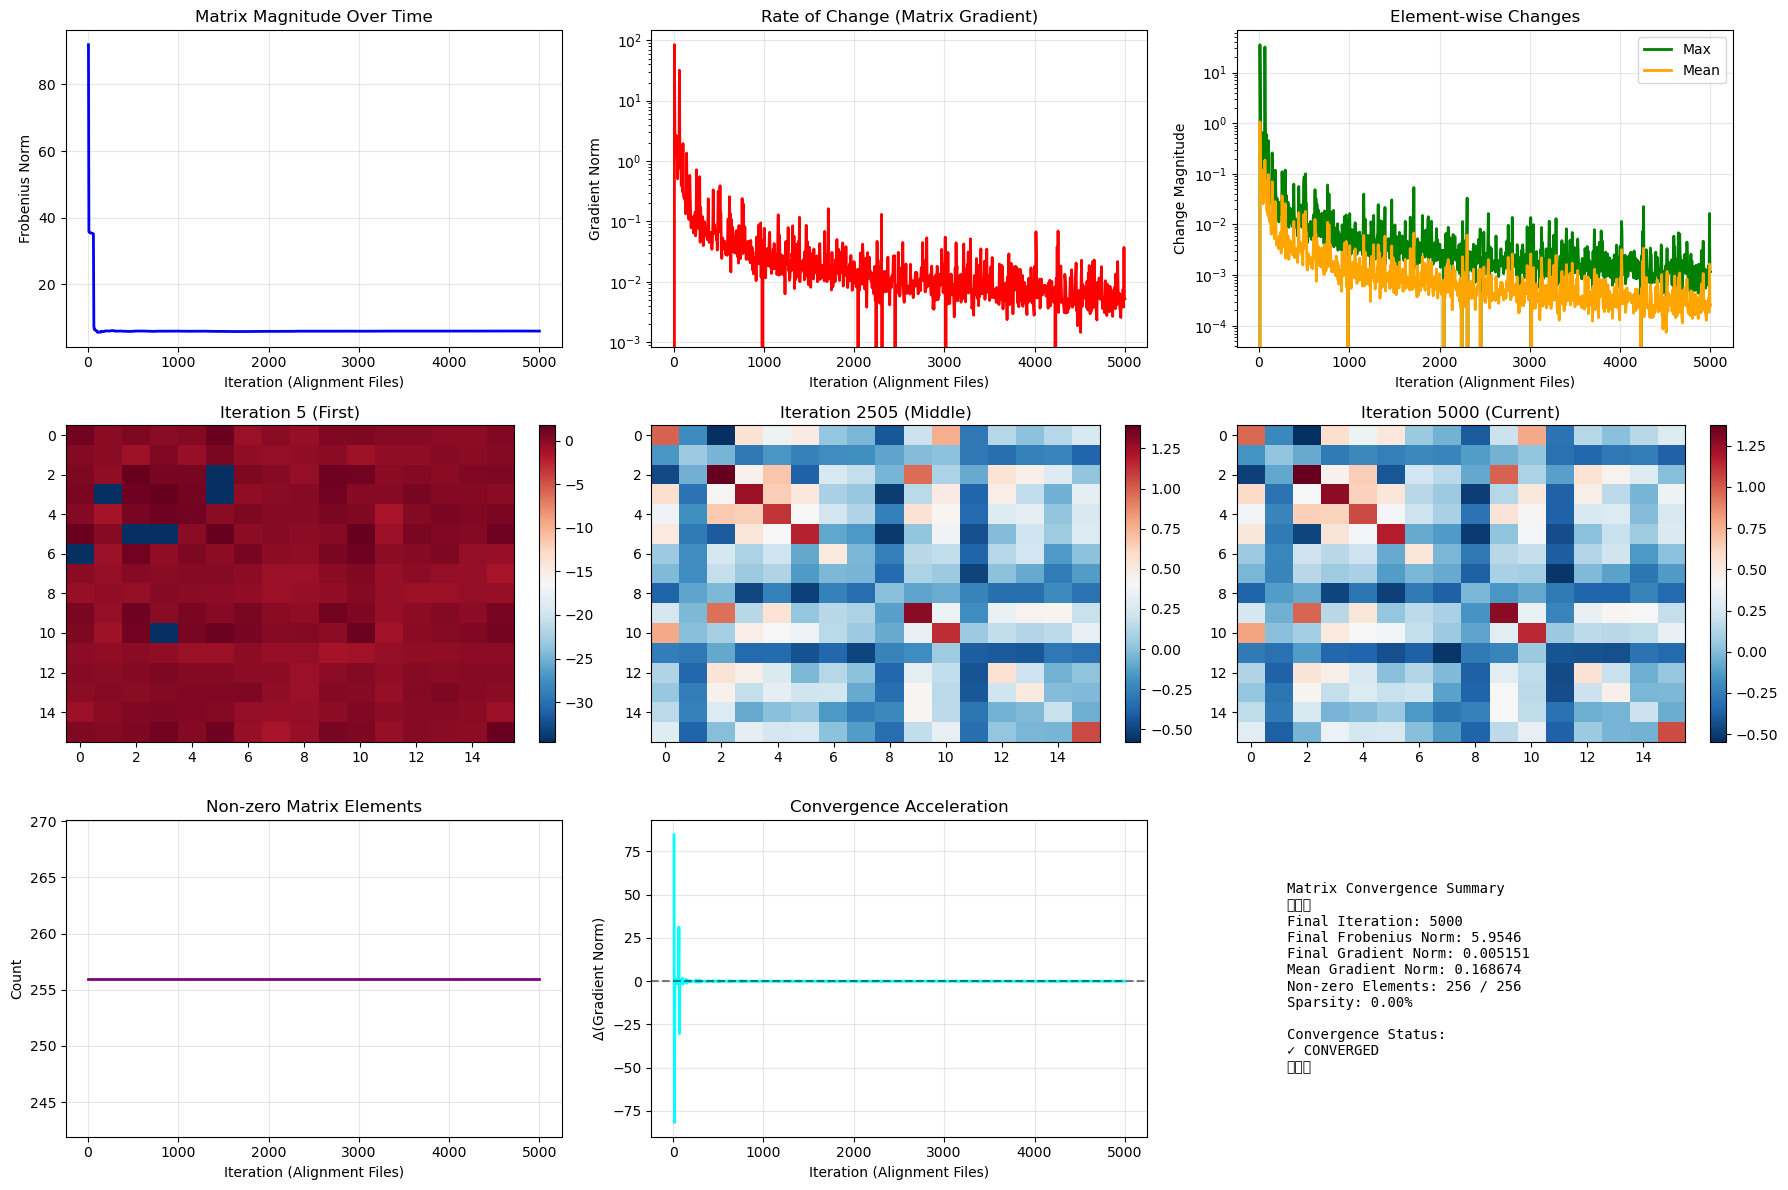

In [36]:
# Final convergence summary and statistics
print("="*80)
print("FINAL CONVERGENCE SUMMARY")
print("="*80)

summary = monitor.get_convergence_summary()
for key, value in summary.items():
	if isinstance(value, float):
		print(f"{key}: {value:.6f}")
	else:
		print(f"{key}: {value}")

print(f"\nTotal pair counts: {np.sum(pair_counts):.0f}")
print(f"Non-zero pairs: {np.count_nonzero(pair_counts)}")
print(f"Sparsity: {100*(1 - np.count_nonzero(pair_counts)/(matrix_size**2)):.2f}%")

# Display final convergence plot
fig = monitor.plot_convergence(figsize=figsize)
plt.savefig(os.path.join(output_dir, f'{modelname}_convergence.png'), dpi=150, bbox_inches='tight')
print(f"\nSaved convergence plot to: {os.path.join(output_dir, f'{modelname}_convergence.png')}")
plt.show()

Computing final log-odds matrix...


Saved final matrix visualization to: ./models/embedding_comparison/final/ft2_35_embeddings_big_best_encoder_final_matrices.png


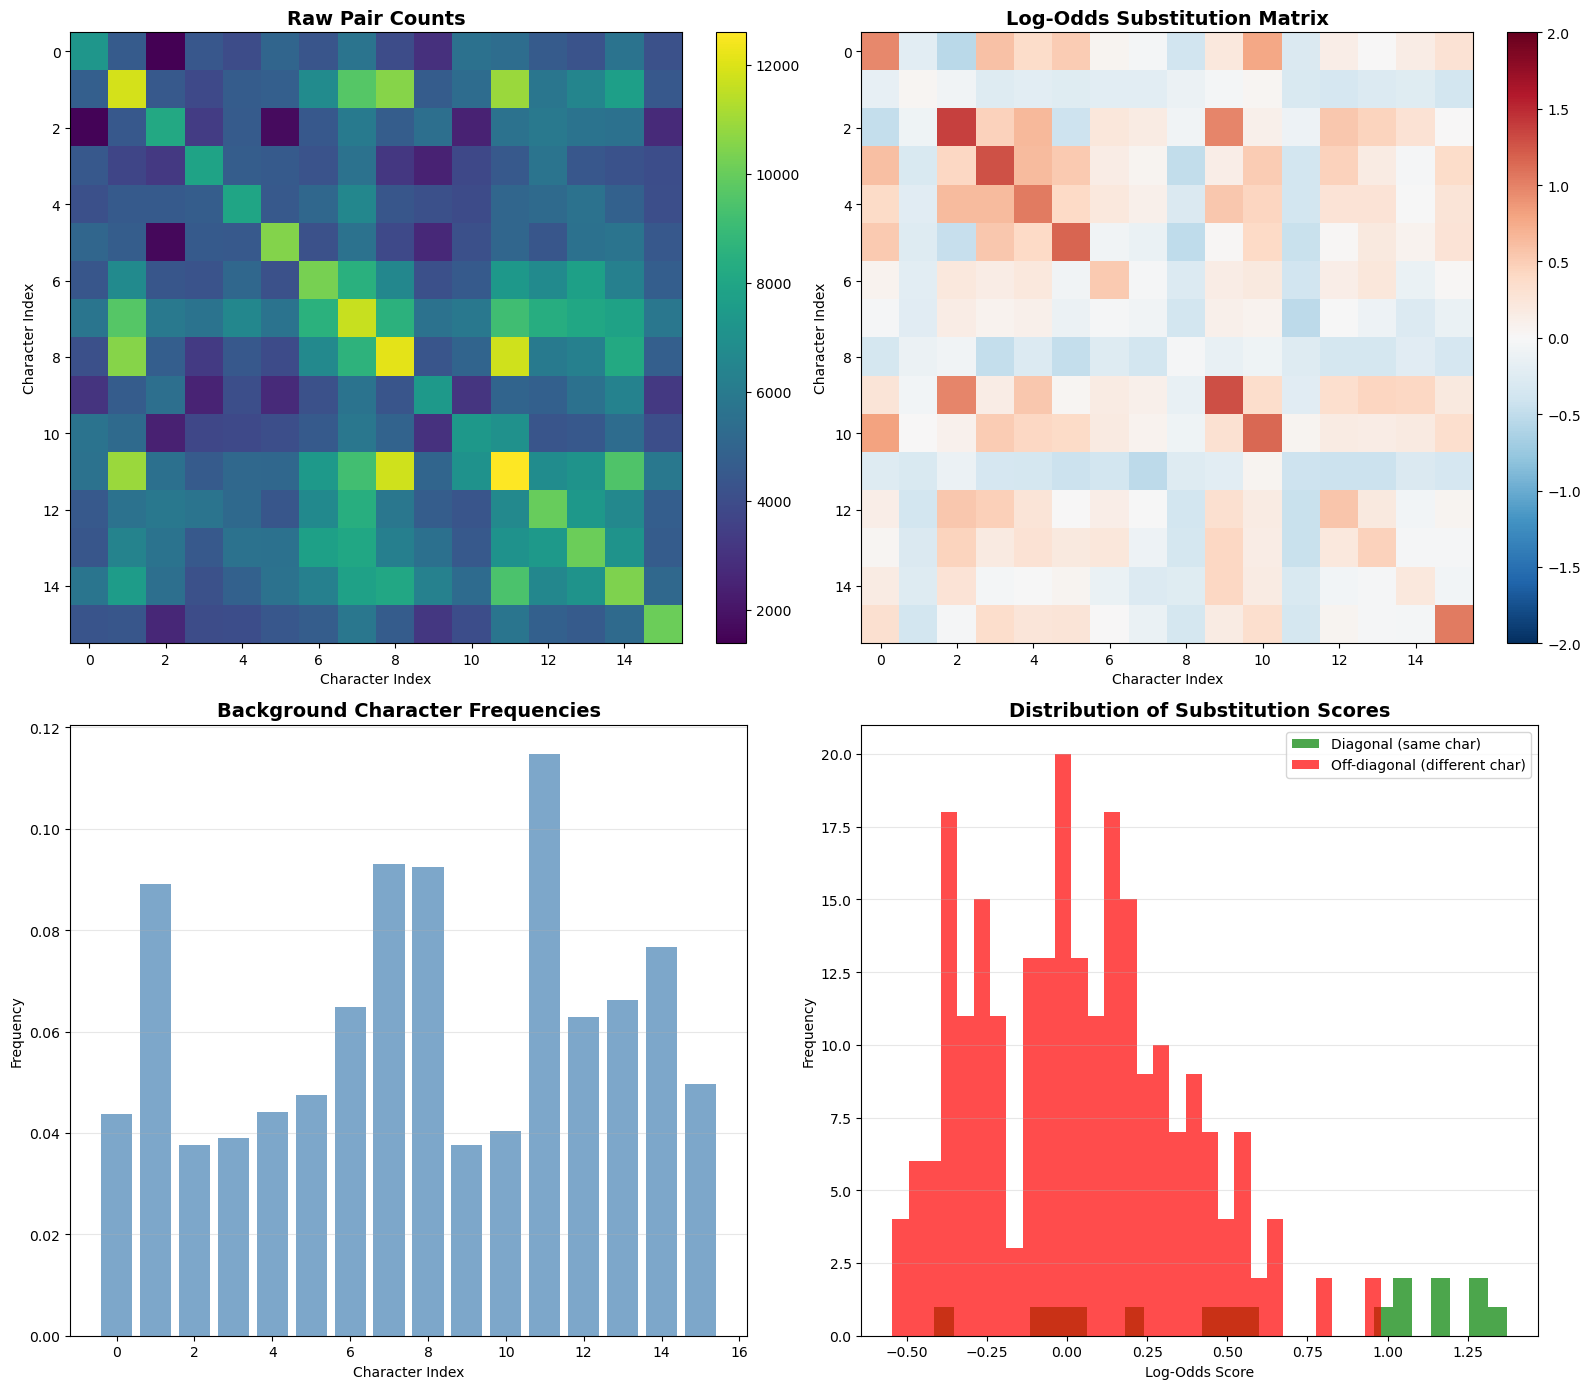


Matrix Statistics:
  Log-odds range: [-0.546, 1.374]
  Mean diagonal score: 0.661
  Mean off-diagonal score: 0.030
  Std diagonal: 0.557
  Std off-diagonal: 0.311


In [37]:
# Compute final substitution matrices

# Normalize background frequencies
background_freq = background_freq / np.sum(background_freq)

# Compute log-odds matrix
print("Computing final log-odds matrix...")
log_odds_matrix = compute_log_odds_from_counts(pair_counts, background_freq)

# Visualize final matrices
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Raw pair counts
im0 = axes[0, 0].imshow(pair_counts, cmap='viridis', aspect='auto', interpolation='nearest')
axes[0, 0].set_title('Raw Pair Counts', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Character Index')
axes[0, 0].set_ylabel('Character Index')
plt.colorbar(im0, ax=axes[0, 0], fraction=0.046)

# Log-odds scores
im1 = axes[0, 1].imshow(log_odds_matrix, cmap='RdBu_r', aspect='auto', 
						interpolation='nearest', vmin=-2, vmax=2)
axes[0, 1].set_title('Log-Odds Substitution Matrix', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Character Index')
axes[0, 1].set_ylabel('Character Index')
plt.colorbar(im1, ax=axes[0, 1], fraction=0.046)

# Background frequencies
axes[1, 0].bar(range(len(background_freq)), background_freq, color='steelblue', alpha=0.7)
axes[1, 0].set_xlabel('Character Index')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Background Character Frequencies', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Diagonal vs off-diagonal scores
diagonal = np.diag(log_odds_matrix)
off_diagonal = log_odds_matrix[~np.eye(matrix_size, dtype=bool)]

axes[1, 1].hist(diagonal, bins=30, alpha=0.7, label='Diagonal (same char)', color='green')
axes[1, 1].hist(off_diagonal, bins=30, alpha=0.7, label='Off-diagonal (different char)', color='red')
axes[1, 1].set_xlabel('Log-Odds Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Substitution Scores', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, f'{modelname}_final_matrices.png'), dpi=150, bbox_inches='tight')
print(f"Saved final matrix visualization to: {os.path.join(output_dir, f'{modelname}_final_matrices.png')}")
plt.show()

print(f"\nMatrix Statistics:")
print(f"  Log-odds range: [{np.min(log_odds_matrix):.3f}, {np.max(log_odds_matrix):.3f}]")
print(f"  Mean diagonal score: {np.mean(diagonal):.3f}")
print(f"  Mean off-diagonal score: {np.mean(off_diagonal):.3f}")
print(f"  Std diagonal: {np.std(diagonal):.3f}")
print(f"  Std off-diagonal: {np.std(off_diagonal):.3f}")

In [38]:
# Output MAFFT-compatible matrix

def output_mafft_matrix(submat, char_set, char_position_map, outpath):
	"""Write substitution matrix in MAFFT format."""
	def formathex(hexnum):
		if len(hexnum) == 3:
			return hexnum[0:2] + '0' + hexnum[2]
		else:
			return hexnum
	
	reverse_char_map = {v: k for k, v in char_position_map.items()}
	
	with open(outpath, 'w') as f:
		for i in range(len(char_set)):
			for j in range(len(char_set)):
				if i <= j:
					stringi = reverse_char_map[i]
					stringj = reverse_char_map[j]
					hexi = formathex(hex(ord(stringi)))
					hexj = formathex(hex(ord(stringj)))
					f.write(f'{hexi} {hexj} {submat[i,j]}\n')

mafft_path = os.path.join(output_dir, f'{modelname}_mafftmat.mtx')
output_mafft_matrix(log_odds_matrix, char_set, char_position_map, mafft_path)
print(f"MAFFT matrix saved to: {mafft_path}")
print(f"  Format: Upper triangular with hex character codes")
print(f"  Size: {matrix_size}x{matrix_size}")

MAFFT matrix saved to: ./models/embedding_comparison/final/ft2_35_embeddings_big_best_encoder_mafftmat.mtx
  Format: Upper triangular with hex character codes
  Size: 16x16


In [39]:
# Output RAxML-compatible matrix

def compute_raxml_compatible_matrix(pair_counts, char_freqs, raxml_charset, 
									raxml_char_position_map, pseudocount=1e-20, 
									log_base=np.e, scaling_factor=1.0):
	"""Compute time-reversible rate matrix for RAxML."""
	# Compute log odds
	log_odds_matrix = compute_log_odds_from_counts(pair_counts, char_freqs, 
													pseudocount, log_base)
	
	# Exponentiate to get relative rates
	preliminary_rates = np.exp(log_odds_matrix * scaling_factor)
	
	# Symmetrize for reversibility
	n = preliminary_rates.shape[0]
	rate_matrix = np.zeros_like(preliminary_rates)
	for i in range(n):
		for j in range(n):
			if i != j:
				rate_matrix[i, j] = (preliminary_rates[i, j] + preliminary_rates[j, i]) / 2.0
	
	# Set diagonal so rows sum to zero
	for i in range(n):
		rate_matrix[i, i] = -np.sum(rate_matrix[i, :]) + rate_matrix[i, i]
	
	# Scale so expected rate = 1
	char_freqs = char_freqs / np.sum(char_freqs)
	expected_rate = -np.sum(char_freqs * np.diag(rate_matrix))
	rate_matrix = rate_matrix / expected_rate
	
	return rate_matrix, char_freqs

def output_raxml_matrix(matrix, background_frequencies, outpath):
	"""Write RAxML-compatible matrix."""
	with open(outpath, "w") as f:
		# Lower triangular matrix
		for i in range(matrix.shape[0]):
			for j in range(matrix.shape[0]):
				if j < i:
					f.write(f" {matrix[i,j]:.6f}")
			f.write("\n")
		# Frequencies
		for i, freq in enumerate(background_frequencies):
			f.write(f"{freq:.6f} ")
		f.write("\n")

raxml_matrix, char_freqs = compute_raxml_compatible_matrix(
	pair_counts, background_freq, raxml_charset, raxml_char_position_map, 
	scaling_factor=1.0
)

raxml_path = os.path.join(output_dir, f'{modelname}_submat.txt')
output_raxml_matrix(raxml_matrix, char_freqs, raxml_path)
print(f"\nRAxML matrix saved to: {raxml_path}")
print(f"  Format: Lower triangular + frequencies")
print(f"  Size: {matrix_size}x{matrix_size}")
print(f"  Time-reversible: Yes")
print(f"  Expected substitution rate: 1.0")


RAxML matrix saved to: ./models/embedding_comparison/final/ft2_35_embeddings_big_best_encoder_submat.txt
  Format: Lower triangular + frequencies
  Size: 16x16
  Time-reversible: Yes
  Expected substitution rate: 1.0


In [40]:
# Save intermediate results for future use

results_path = os.path.join(output_dir, f'{modelname}_pair_counts.pkl')
with open(results_path, 'wb') as f:
	pickle.dump({
		'pair_counts': pair_counts,
		'char_set': char_set,
		'char_position_map': char_position_map,
		'raxml_charset': raxml_charset,
		'raxml_char_position_map': raxml_char_position_map,
		'background_freq': background_freq,
		'convergence_history': monitor.history
	}, f)

print(f"Saved intermediate results to: {results_path}")
print("\nSaved data includes:")
print("  - Pair counts matrix")
print("  - Character sets and mappings")
print("  - Background frequencies")
print("  - Full convergence history")

Saved intermediate results to: ./models/embedding_comparison/final/ft2_35_embeddings_big_best_encoder_pair_counts.pkl

Saved data includes:
  - Pair counts matrix
  - Character sets and mappings
  - Background frequencies
  - Full convergence history


## Analysis: Matrix Evolution Over Time

Visualize how specific substitution scores evolved during the iteration process.

Saved evolution analysis to: ./models/embedding_comparison/final/ft2_35_embeddings_big_best_encoder_evolution_analysis.png


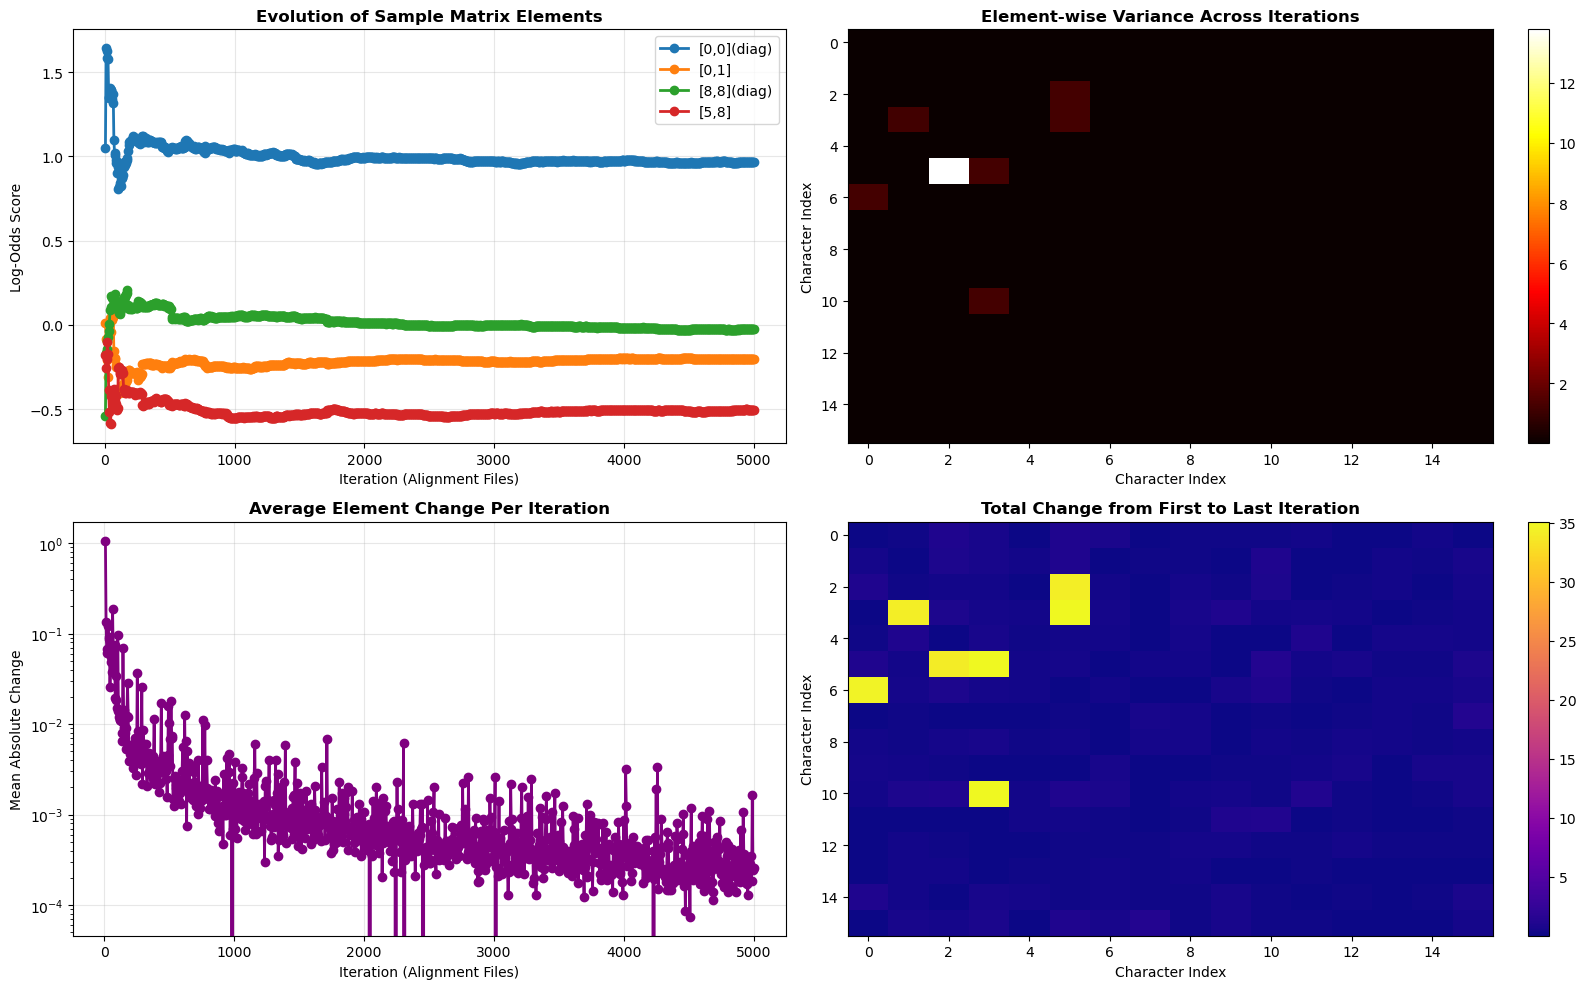


Evolution Statistics:
  Initial mean change: 1.062283
  Final mean change: 0.000260
  Reduction factor: 4093.33x
  Most variable position: (5, 2)
  Max variance: 13.783494


In [41]:
# Track evolution of specific matrix elements over time

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Select sample matrix positions to track
sample_positions = [
	(0, 0),  # Diagonal element
	(0, 1),  # Adjacent off-diagonal
	(matrix_size//2, matrix_size//2),  # Middle diagonal
	(5, 8)  # Random off-diagonal
]

iterations = monitor.history['iteration']

# Plot 1: Evolution of sample positions
for pos in sample_positions:
	values = [snapshot[pos] for snapshot in monitor.history['snapshots']]
	label = f'[{pos[0]},{pos[1]}]{"(diag)" if pos[0]==pos[1] else ""}'
	axes[0, 0].plot(iterations, values, marker='o', linewidth=2, label=label)

axes[0, 0].set_xlabel('Iteration (Alignment Files)')
axes[0, 0].set_ylabel('Log-Odds Score')
axes[0, 0].set_title('Evolution of Sample Matrix Elements', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Variance across iterations for each position
if len(monitor.history['snapshots']) > 3:
	snapshot_array = np.array(monitor.history['snapshots'])
	element_variance = np.var(snapshot_array, axis=0)
	
	im = axes[0, 1].imshow(element_variance, cmap='hot', aspect='auto', interpolation='nearest')
	axes[0, 1].set_title('Element-wise Variance Across Iterations', fontweight='bold')
	axes[0, 1].set_xlabel('Character Index')
	axes[0, 1].set_ylabel('Character Index')
	plt.colorbar(im, ax=axes[0, 1], fraction=0.046)

# Plot 3: Mean absolute change per iteration
mean_abs_changes = []
for i in range(1, len(monitor.history['snapshots'])):
	change = np.abs(monitor.history['snapshots'][i] - monitor.history['snapshots'][i-1])
	mean_abs_changes.append(np.mean(change))

if len(mean_abs_changes) > 0:
	axes[1, 0].plot(iterations[1:], mean_abs_changes, 'purple', linewidth=2, marker='o')
	axes[1, 0].set_xlabel('Iteration (Alignment Files)')
	axes[1, 0].set_ylabel('Mean Absolute Change')
	axes[1, 0].set_title('Average Element Change Per Iteration', fontweight='bold')
	axes[1, 0].set_yscale('log')
	axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Cumulative changes heatmap
if len(monitor.history['snapshots']) > 1:
	cumulative_change = np.abs(monitor.history['snapshots'][-1] - monitor.history['snapshots'][0])
	im = axes[1, 1].imshow(cumulative_change, cmap='plasma', aspect='auto', interpolation='nearest')
	axes[1, 1].set_title('Total Change from First to Last Iteration', fontweight='bold')
	axes[1, 1].set_xlabel('Character Index')
	axes[1, 1].set_ylabel('Character Index')
	plt.colorbar(im, ax=axes[1, 1], fraction=0.046)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, f'{modelname}_evolution_analysis.png'), dpi=150, bbox_inches='tight')
print(f"Saved evolution analysis to: {os.path.join(output_dir, f'{modelname}_evolution_analysis.png')}")
plt.show()

# Print statistics
if len(mean_abs_changes) > 0:
	print(f"\nEvolution Statistics:")
	print(f"  Initial mean change: {mean_abs_changes[0]:.6f}")
	print(f"  Final mean change: {mean_abs_changes[-1]:.6f}")
	print(f"  Reduction factor: {mean_abs_changes[0]/mean_abs_changes[-1]:.2f}x")
	print(f"  Most variable position: {np.unravel_index(element_variance.argmax(), element_variance.shape)}")
	print(f"  Max variance: {np.max(element_variance):.6f}")

## Summary

### Files Generated
1. **MAFFT Matrix**: `{modelname}_mafftmat.mtx` - For MAFFT alignment with custom scoring
2. **RAxML Matrix**: `{modelname}_submat.txt` - For phylogenetic inference with RAxML
3. **Convergence Plot**: `{modelname}_convergence.png` - Real-time monitoring visualization
4. **Final Matrices**: `{modelname}_final_matrices.png` - Matrix structure and statistics
5. **Evolution Analysis**: `{modelname}_evolution_analysis.png` - Element tracking over time
6. **Intermediate Data**: `{modelname}_pair_counts.pkl` - Reusable computation results

### Key Insights from Convergence Monitoring
- **Gradient Norm**: Measures the rate at which the matrix is changing between iterations
- **Frobenius Norm**: Overall magnitude of the matrix values
- **Element Variance**: Identifies which substitution pairs are most sensitive to new data
- **Convergence Status**: Automatically detects when the matrix has stabilized

The real-time visualization helps ensure:
1. The matrix converges to a stable solution
2. No outlier alignment files cause dramatic shifts
3. Sufficient data has been processed for reliable estimates